# MOG, MOG2 et GMG

* BackgroundSubtractorMOG2:
Il s'agit d'un algorithme de segmentation d'arrière-plan / de premier plan basé sur un mélange gaussien
Cet algorithme sélectionne le nombre approprié de distribution gaussienne pour chaque pixel. 
Il offre une meilleure adaptabilité aux différentes scènes en raison des changements d'éclairage, etc.

* createBackgroundSubtractorGMG:
Cet algorithme combine l'estimation statistique de l'image de fond et la segmentation bayésienne par pixel.
Il utilise les premières images pour la modélisation d'arrière-plan. 
Il utilise un algorithme de segmentation probabiliste de premier plan qui identifie les objets possibles 
de premier plan à l'aide de l'inférence bayésienne. Les estimations sont adaptatives; 
Les observations plus récentes sont plus fortement pondérées que les anciennes observations pour 
s'adapter à un éclairage variable. Plusieurs opérations de filtrage morphologique comme la fermeture 
et l'ouverture sont effectuées pour supprimer les bruits indésirables. 
Vous obtiendrez une fenêtre noire pendant les premières images.

* MOG:
Il s'agit d'un algorithme de segmentation d'arrière-plan / de premier plan basé sur un mélange gaussien. 
Il utilise une méthode pour modéliser chaque pixel de fond par un mélange de K distributions gaussiennes ( K = 3 à 5). 
Les poids du mélange représentent les proportions de temps pendant lesquelles ces couleurs restent dans la scène. 
Les couleurs de fond probables sont celles qui restent plus longtemps et les plus statiques.

## MOG

In [1]:
import numpy as np
import cv2

cap = cv2.VideoCapture("seq5.avi")
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()

while(1):
    ret, frame = cap.read()
    fgmask = fgbg.apply(frame)
    
    cv2.imshow('frame', fgmask)
    k = cv2.waitKey(30) & 0xff
    if k==27:
        break
cap.release()
cv2.destroyAllWindows()

c:\users\admin\anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\admin\anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\admin\anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


![MOG](images/MOG.png)

L'arrière-plan est supprimé et seuls les objets en mouvement sont présents

## MOG2

In [2]:
import numpy as np
import cv2

cap = cv2.VideoCapture("seq5.avi")
fgbg = cv2.createBackgroundSubtractorMOG2()

while(1):
    ret, frame = cap.read()
    fgmask = fgbg.apply(frame)
    
    cv2.imshow('frame', fgmask)
    k = cv2.waitKey(30) & 0xff
    if k==27:
        break
cap.release()
cv2.destroyAllWindows()

![MOG2](images/MOG2.png)

## GMG

In [4]:
import numpy as np
import cv2

cap = cv2.VideoCapture("seq5.avi")
fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()

while(1):
    ret, frame = cap.read()
    fgmask = fgbg.apply(frame)
    
    cv2.imshow('frame', fgmask)
    k = cv2.waitKey(30) & 0xff
    if k==27:
        break
cap.release()
cv2.destroyAllWindows()

![GMG](images/GMG.png)

# MeanShift et CamShift

* MeanShift: Considére que vous avez un ensemble de points. (Il peut s'agir d'une distribution de pixels comme une rétroprojection d'histogramme). On vous donne une petite fenêtre (peut-être un cercle) et vous devez déplacer cette fenêtre vers la zone de densité de pixels maximale (ou nombre maximal de points)

* CamShift: Applique meanshift d'abord. Une fois que meanshift converge, il met à jour la taille de la fenêtre. Il calcule aussi l'orientation de l'ellipse qui lui convient le mieux. Encore une fois, il applique meanshift avec la nouvelle fenêtre de recherche mise à l'échelle et l'emplacement de la fenêtre précédente. Le processus se poursuit jusqu'à ce que la précision requise soit atteinte.

## MeanShift

In [5]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
r,h,c,w = 250,90,400,125  # simply hardcoded the values
track_window = (c,r,w,h)

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Draw it on image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv2.imshow('img2',img2)

        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv2.destroyAllWindows()
cap.release()

![meanshift](images/meanshift.png)

## CamShift

In [6]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
r,h,c,w = 250,90,400,125  # simply hardcoded the values
track_window = (c,r,w,h)

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)

        # Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        cv2.imshow('img2',img2)

        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv2.destroyAllWindows()
cap.release()

![camshift](images/camshift.png)

# Block Matching

In [7]:
from block_matching import *
import cv2
from shutil import copyfile

cap = cv2.VideoCapture('seq5.avi')
i=0
while(1):
    try:
        ret, frame = cap.read()
        ret2, frame2 = cap.read()

        main(anchorFrame=frame, targetFrame=frame2, outfile="output", saveOutput=True, blockSize=16, searchArea=7)
        copyfile("./Predicted.PNG", "./output/Predicted"+str(i)+".PNG")
        copyfile("./Residual.PNG", "./output/Residual"+str(i)+".PNG")
        
        cv2.imshow('frame',frame)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break
        i+=1
    except:
        cv2.destroyAllWindows()
        cap.release()
        break
        
cv2.destroyAllWindows()
cap.release()

![block_matching](images/block_matching.png)

En utilisant l'algorithme de block matching avec 16x16 blocs et taille de la zone de recherche de 7, nous obtenons l'image prédite. Nous remarquons que les valeurs non 0 sont autour des objets en mouvement tels que la tête des personnes. 

La soustraction des trames cible et prédite produit la trame résiduelle. Il s'agit de la petite quantité de données qui n'a pas été capturée par la trame prédite et qui doit être codée pendant le processus de compression.

# Flux optique

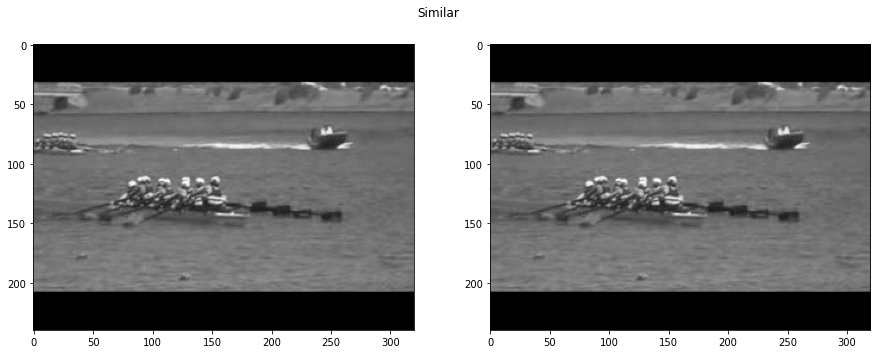

PSNR DF 52.29769389753275
PSNR DFD 35.272213679444874


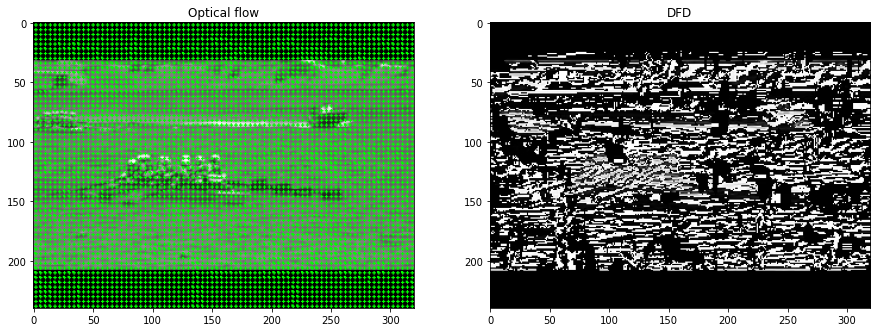

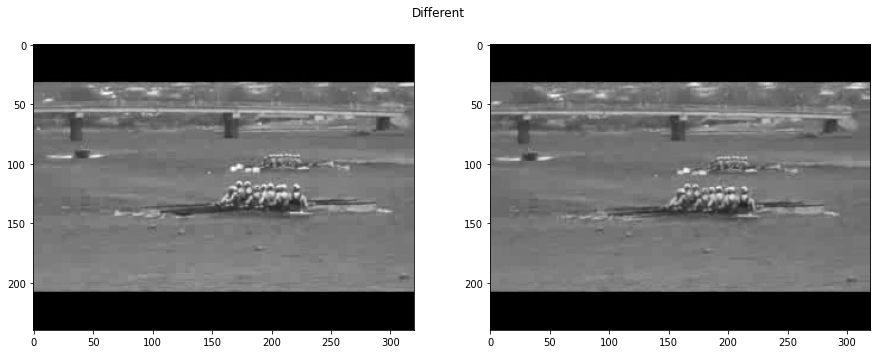

PSNR DF 32.58484110558148
PSNR DFD 31.203421939993067


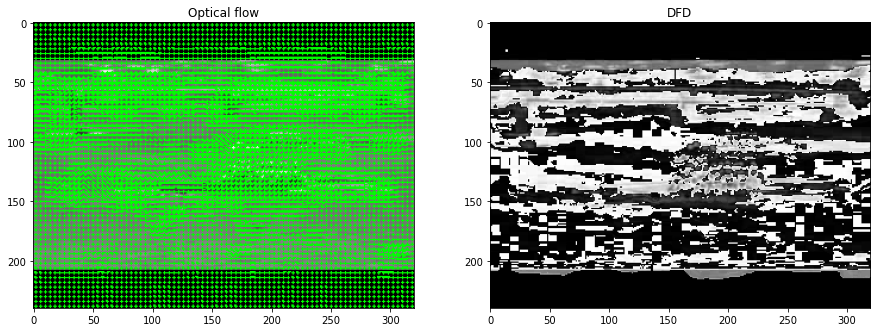

In [2]:
import cv2 
import numpy as np
import itertools
from math import log10, sqrt 
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt

class OpticalFlow:
    def __init__(self, path_video):
        self.path_video = path_video
        self.frame_info = np.array([])
        self.different_frames = np.array([])
        
    def PSNR(self, mydfd): 
        mse = np.mean(mydfd ** 2) 
        if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                      # Therefore PSNR have no importance.
            print('mse=0!, arbitrary PSNR=100')          
            return 100
        max_pixel = 255.0
        psnr = 20 * log10(max_pixel / sqrt(mse)) 
        return psnr

    def draw_flow(self, im,flow,step=4):
           h,w = im.shape[:2]
           #y,x = np.mgrid[step/2:h:step,step/2:w:step].reshape(2,-1)
           y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int) 
           fx,fy = flow[y,x].T

           # create line endpoints
           lines = np.vstack([x,y,x+fx,y+fy]).T.reshape(-1,2,2)
           lines = np.int32(lines)

           # create image and draw
           vis = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
           for (x1,y1),(x2,y2) in lines:
               cv2.line(vis,(x1,y1),(x2,y2),(0,255,0),1)
               cv2.circle(vis,(x1,y1),1,(0,255,0), -1)
           return vis

    def dfd(self, previous,current,flow):
        height, width = previous.shape[:2]

        # allocate "reconstruct" only once

       #reconstructed = np.empty(previous.shape)
        reconstructed = np.zeros_like(previous)

        for x, y in itertools.product(range(width), range(height)):
            dy, dx = flow[y, x]
            rx = int(max(0, min(x + dx, width - 1)))
            ry = int(max(0, min(y + dy, height - 1)))
            reconstructed[y, x] = current[ry, rx]
        return np.abs(previous-reconstructed)
    
    def main_utile(self, prvs, _next, frame1, x_winsize=15):
        #Arrange the flow as HSV image
        hsv = np.zeros_like(frame1)
        #Saturation S valeur arbitraire 255
        hsv[...,1] = 255
        flow = cv2.calcOpticalFlowFarneback(prvs,_next, None, pyr_scale=0.5, levels=3, winsize=x_winsize,
                                            iterations=15, poly_n=5, poly_sigma=1.2, flags=0)


        #Saturation S valeur arbitraire 255
        hsv[...,1] = 255
        #Direction of the flow corresponds to Hue value of the image
        #Magnitude of the flow corresponds to Value plane
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        #Convert the HSV image into RGB one
        rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)        # cv2.imshow('frame2',rgb)

        #Store the colored optical flow
        cv2.imwrite('akiOF_hsv.png',rgb)

        #Store the flow vectors
        cv2.imwrite('akiOF.jpg',self.draw_flow(prvs,flow))

        #compute the Frame Difference (FD)
        FD=np.abs(prvs-_next)
        cv2.imwrite('akiDF.jpg',FD)
        print("PSNR DF", self.PSNR(FD))

        #compute the displaced frame difference
        myDFD=self.dfd(prvs,_next, flow) 
        print('PSNR DFD', self.PSNR(myDFD))

        plt.figure(figsize=(15, 15))
        plt.subplot(1,2,1)
        plt.title('Optical flow')
        plt.imshow(self.draw_flow(prvs,flow))
        plt.subplot(1,2,2)
        plt.title('DFD')
        plt.imshow(myDFD, cmap='gray')
        plt.show()

        cv2.imwrite('akiDFD.jpg',myDFD)
        
        
    def main(self):
        # Compute structural_similarity between two images

        cap = cv2.VideoCapture(self.path_video)
        ret, frame1 = cap.read()

        prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
        similarity=[]
        frame_list=[]
        while(1):
            ret, frame2 = cap.read()
            if ret:
                # next= frame2
                _next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

                (score, diff) = structural_similarity(prvs, _next, full=True)

                similarity.append(score)
                frame_list.append((prvs, _next))

                if cv2.waitKey(20) & 0xFF == ord('q'):
                    break
                prvs = _next

            else:
                break

        cap.release()
        cv2.destroyAllWindows()
        
        similarity=np.array(similarity)
        similar_frames = frame_list[np.argmax(similarity)]  
        self.different_frames = frame_list[np.argmin(similarity)] 
        
        #similar
        plt.figure(figsize=(15, 15))
        plt.subplot(1,2,1)
        plt.imshow(similar_frames[0], cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(similar_frames[1], cmap='gray')
        plt.suptitle('Similar')
        plt.subplots_adjust(top=1.5)
        plt.show()

        self.main_utile(similar_frames[0], similar_frames[1], frame1)
        
        #different
        plt.figure(figsize=(15, 15))
        plt.subplot(1,2,1)
        plt.imshow(self.different_frames[0], cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(self.different_frames[1], cmap='gray')
        plt.suptitle('Different')
        plt.subplots_adjust(top=1.5)
        plt.show()

        self.main_utile(self.different_frames[0], self.different_frames[1], frame1)

        
if __name__ == "__main__":
    optical_flow = OpticalFlow('./seq5.avi')
    optical_flow.main()
    

# Lucas et Kanade

In [3]:
import numpy as np
import cv2

cap = cv2.VideoCapture('seq5.avi')

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 30,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 10,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

![Lucas_et_Kanade](images/Lucas_et_Kanade.png)